In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

df = pd.read_excel(r"C:\Users\brend\OneDrive - Stonehill College\All Cape League Trackman.xlsx")

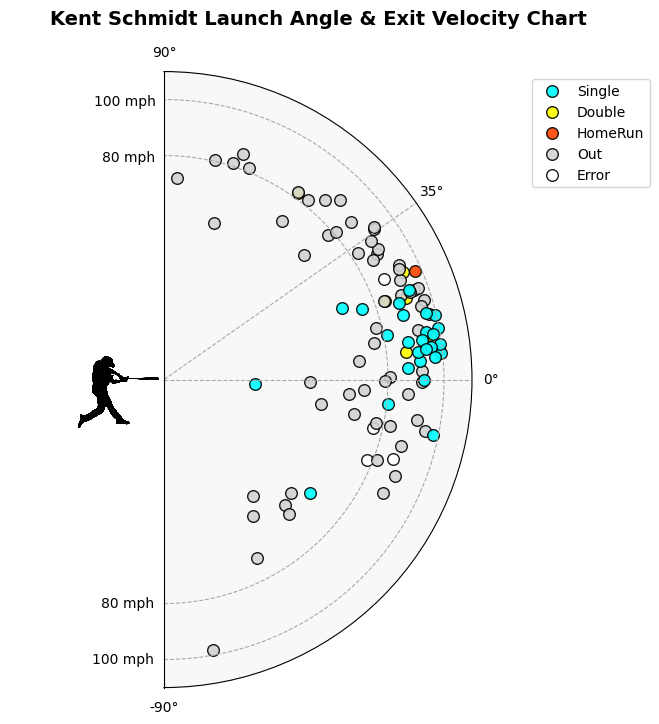

In [20]:
player_name = "Schmidt, Kent"

valid_outcomes = ["Single", "Double", "HomeRun", "Out", "Error"]

player_df = df[
    (df["Batter"] == player_name) &
    (df["PlayResult"].isin(valid_outcomes)) &
    (~df["PitchCall"].str.contains("FoulBallNotFieldable", case=False, na=False))
]

color_map = {
    "Single": "cyan",
    "Double": "yellow",
    "HomeRun": "orangered",
    "Out": "lightgrey",
    "Error": "white"
}

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="polar")

angles = np.radians(np.linspace(-90, 90, 500))
radius = np.full_like(angles, 110)
ax.fill_between(angles, 0, radius, color="lightgray", alpha=.15)

ax.grid(color='darkgray', linewidth=0.8, linestyle='--')
ax.tick_params(colors='black', which='both')
ax.spines['polar'].set_color('black')

for outcome, group in player_df.groupby("PlayResult"):
    ax.scatter(
        np.radians(group["Angle"]),
        group["ExitSpeed"],
        label=outcome,
        color=color_map.get(outcome, "black"),
        edgecolor="black",
        s=70, alpha=0.9
    )

ax.set_theta_zero_location("E")
ax.set_theta_direction(1)
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_ylim(0, 110)

ax.set_yticks([80, 100])
ax.set_yticklabels(["80 mph", "100 mph"], fontsize=10)

top_offsets = [9.25, 8.25]
radial_offset = 2
for r, label, offset in zip([80, 100], ["80 mph", "100 mph"], top_offsets):
    ax.text(np.radians(90 + offset), r - radial_offset, label,
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

ax.set_xticks(np.radians([-90, 0, 35, 90]))
ax.set_xticklabels(["-90°", "0°", "35°", "90°"], fontsize=10)

ax.set_title(f"Kent Schmidt Launch Angle & Exit Velocity Chart",
             fontsize=14, fontweight="bold", pad=15)

handles, labels = ax.get_legend_handles_labels()
order = ["Single", "Double", "HomeRun", "Out", "Error"]

handle_dict = dict(zip(labels, handles))

ordered_handles = [handle_dict[o] for o in order if o in handle_dict]
ordered_labels = [o for o in order if o in handle_dict]

ax.legend(ordered_handles, ordered_labels, loc="upper right", bbox_to_anchor=(1.05, 1))

img = mpimg.imread(r"C:\Users\brend\Downloads\baseball2.png")
imagebox = OffsetImage(img, zoom=0.09)

ab = AnnotationBbox(imagebox,
                    (0.175, 0.479),
                    xycoords='axes fraction',
                    frameon=False)

ax.add_artist(ab)

plt.show()

C:\Users\brend\AppData\Local\Temp\ipykernel_14640\2243429165.py:48: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


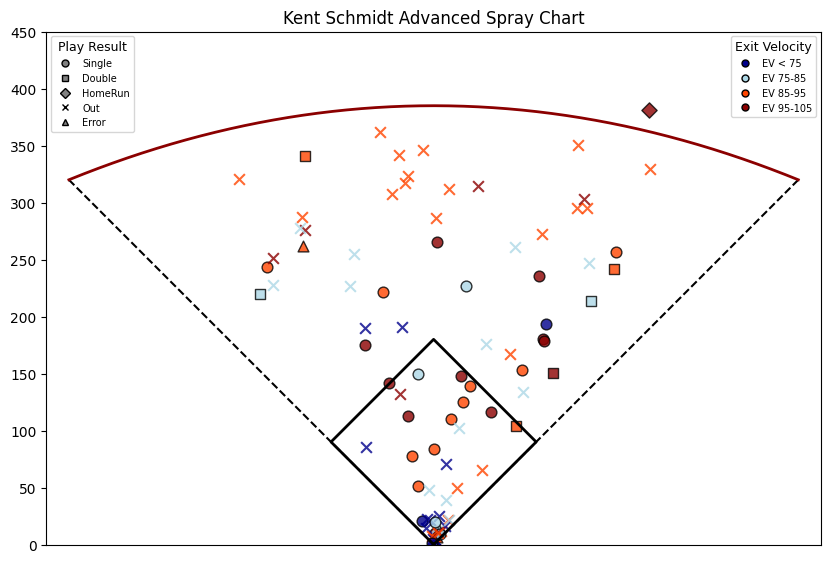

In [3]:
player_name = "Schmidt, Kent"
player_df = df[df["Batter"] == player_name].copy()

player_df = player_df[~player_df['PitchCall'].str.contains("FoulBallNotFieldable", case=False, na=False)]
player_df = player_df.dropna(subset=['Distance', 'Bearing', 'ExitSpeed', 'PlayResult'])

player_df['X'] = player_df['Distance'] * np.sin(np.radians(player_df['Bearing']))
player_df['Y'] = player_df['Distance']

marker_map = {"Single": "o", "Double": "s", "HomeRun": "D", "Out": "x", "Error": "^"}

def velocity_color(ev):
    if ev < 75:
        return "darkblue"
    elif ev < 85:
        return "lightblue"
    elif ev < 95:
        return "orangered"
    elif ev < 105:
        return "darkred"
    else:
        return "black"

fig, ax = plt.subplots(figsize=(10, 8))

infield = np.array([[0, 0], [-90, 90], [0, 180], [90, 90], [0, 0]])
ax.plot(infield[:, 0], infield[:, 1], color='black', linewidth=2)

ax.plot([-320, 0], [320, 0], color='black', linestyle='--', linewidth=1.5)
ax.plot([0, 320], [0, 320], color='black', linestyle='--', linewidth=1.5)

lf_foul_pole_x, lf_foul_pole_y = -320, 320
dead_center_x, dead_center_y = 0, 385
rf_foul_pole_x, rf_foul_pole_y = 320, 320

x_wall = np.array([lf_foul_pole_x, dead_center_x, rf_foul_pole_x])
y_wall = np.array([lf_foul_pole_y, dead_center_y, rf_foul_pole_y])
coeffs = np.polyfit(x_wall, y_wall, 2)
x_vals = np.linspace(lf_foul_pole_x, rf_foul_pole_x, 400)
y_vals = np.polyval(coeffs, x_vals)
ax.plot(x_vals, y_vals, color='darkred', linewidth=2)

for _, row in player_df.iterrows():
    ax.scatter(
        row['X'], row['Y'],
        marker=marker_map.get(row['PlayResult'], "o"),
        color=velocity_color(row['ExitSpeed']),
        s=60,
        edgecolor='black',
        alpha=0.8
    )

marker_handles = [Line2D([0], [0], marker=m, color='w', label=l,
                         markerfacecolor='gray', markersize=5, markeredgecolor='black')
                  for l, m in marker_map.items()]

color_map = [("EV < 75", "darkblue"),
             ("EV 75-85", "lightblue"),
             ("EV 85-95", "orangered"),
             ("EV 95-105", "darkred")]

color_handles = [Line2D([0], [0], marker='o', color='w', label=l,
                        markerfacecolor=c, markersize=5, markeredgecolor='black')
                 for l, c in color_map]

first_legend = ax.legend(handles=marker_handles, title="Play Result", loc='upper left', fontsize=7, title_fontsize=9)
ax.add_artist(first_legend)
ax.legend(handles=color_handles, title="Exit Velocity", loc='upper right', fontsize=7, title_fontsize=9)

ax.set_xlim(-340, 340)
ax.set_ylim(0, 450)
ax.set_aspect('equal')
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_title(f"Kent Schmidt Advanced Spray Chart")
plt.show()

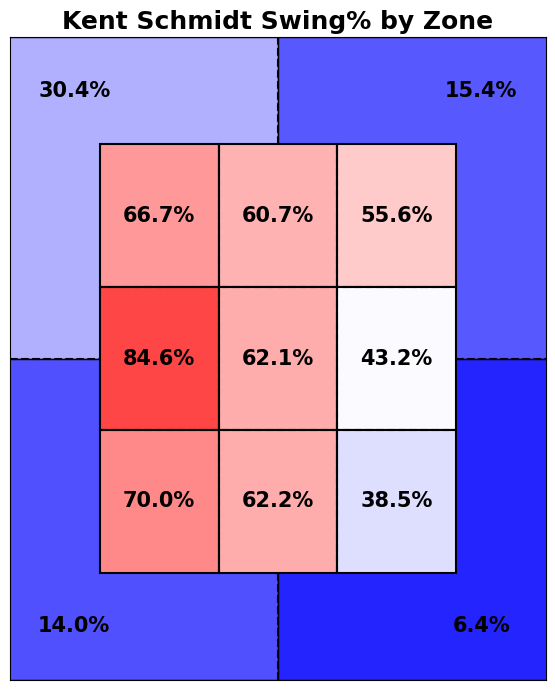

In [95]:
player_name = "Schmidt, Kent"
player_df = df[df["Batter"] == player_name].copy()
player_df = player_df.dropna(subset=["PlateLocSide", "PlateLocHeight"])

swing_events = ["FoulBallFieldable", "FoulBallNotFieldable", "InPlay", "StrikeSwinging"]
player_df["Swing"] = player_df["PitchCall"].isin(swing_events)

sz_left, sz_right = -0.83, 0.83
sz_bottom, sz_top = 1.5, 3.5
mid_x = (sz_left + sz_right) / 2
mid_y = (sz_bottom + sz_top) / 2

x_bins = [sz_left, sz_left + (sz_right - sz_left)/3,
          sz_left + 2*(sz_right - sz_left)/3, sz_right]
y_bins = [sz_bottom, sz_bottom + (sz_top - sz_bottom)/3,
          sz_bottom + 2*(sz_top - sz_bottom)/3, sz_top]

def assign_zone(row):
    x = row["PlateLocSide"]
    y = row["PlateLocHeight"]

    if sz_left <= x <= sz_right and sz_bottom <= y <= sz_top:
        col = sum([x > x_bins[1], x > x_bins[2]])
        row_idx = sum([y > y_bins[1], y > y_bins[2]])
        return f"Z{2-row_idx}{col}"

    if y > sz_top and x < mid_x:
        return "O_top_left"
    if y > sz_top and x >= mid_x:
        return "O_top_right"
    if y < sz_bottom and x < mid_x:
        return "O_bottom_left"
    if y < sz_bottom and x >= mid_x:
        return "O_bottom_right"
    return None

player_df["Zone"] = player_df.apply(assign_zone, axis=1)

swing_stats = (
    player_df.groupby("Zone")
    .agg(total_pitches=("Swing", "size"), swings=("Swing", "sum"))
    .reset_index()
)
swing_stats["Swing%"] = (swing_stats["swings"] / swing_stats["total_pitches"]) * 100
swing_dict = swing_stats.set_index("Zone")["Swing%"].to_dict()

cmap = plt.cm.bwr
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=44, vmax=100)

fig, ax = plt.subplots(figsize=(6, 7))

outer_rects = {

    "O_top_left":    (sz_left-0.8, sz_top-1, (sz_right-sz_left)/2+0.8, 1.5),
    "O_top_right":   (mid_x, sz_top-1, (sz_right-sz_left)/2+0.8, 1.5),

    "O_bottom_left": (sz_left-0.8, sz_bottom-.5, (sz_right-sz_left)/2+0.8, 1.5),
    "O_bottom_right":(mid_x, sz_bottom-.5, (sz_right-sz_left)/2+0.8, 1.5),
}


for zone, (x, y, w, h) in outer_rects.items():
    if zone in swing_dict:
        val = swing_dict[zone]
        color = cmap(norm(val))
        rect = Rectangle((x, y), w, h, facecolor=color,
                         edgecolor="black", linewidth=1, zorder=0)
        ax.add_patch(rect)

outer_positions = {
    "O_top_left":    (mid_x - 0.95, sz_top + 0.25),
    "O_top_right":   (mid_x + 0.95, sz_top + 0.25),
    "O_bottom_left": (mid_x - 0.95, sz_bottom - 0.25),
    "O_bottom_right":(mid_x + 0.95, sz_bottom - 0.25)
}

for zone, (cx, cy) in outer_positions.items():
    if zone in swing_dict:
        ax.text(cx, cy, f"{swing_dict[zone]:.1f}%",
                ha="center", va="center", fontsize=15, fontweight="bold")

for row_idx in range(3):
    for col in range(3):
        zone = f"Z{row_idx}{col}"
        if zone in swing_dict:
            val = swing_dict[zone]
            color = cmap(norm(val))
            rect = Rectangle(
                (sz_left + col*(sz_right-sz_left)/3,
                 sz_bottom + (2-row_idx)*(sz_top-sz_bottom)/3),
                (sz_right-sz_left)/3,
                (sz_top-sz_bottom)/3,
                facecolor=color,
                edgecolor="black",
                linewidth=1.5,
                zorder=1
            )
            ax.add_patch(rect)

            cx = sz_left + (col+0.5)*(sz_right-sz_left)/3
            cy = sz_bottom + (2-row_idx+0.5)*(sz_top-sz_bottom)/3
            ax.text(cx, cy, f"{val:.1f}%", ha="center", va="center",
                    fontsize=15, fontweight="bold", zorder=2)

for i in range(1, 3):
    ax.plot([sz_left + i*(sz_right-sz_left)/3]*2, [sz_bottom, sz_top],
            color="black", linestyle="--", zorder=3)
    ax.plot([sz_left, sz_right], [sz_bottom + i*(sz_top-sz_bottom)/3]*2,
            color="black", linestyle="--", zorder=3)

ax.plot([sz_left-0.8, sz_left], [mid_y, mid_y], color="black", linestyle="--")
ax.plot([sz_right, sz_right+0.8], [mid_y, mid_y], color="black", linestyle="--")
ax.plot([mid_x, mid_x], [sz_top, sz_top+0.5], color="black", linestyle="--")
ax.plot([mid_x, mid_x], [sz_bottom-0.5, sz_bottom], color="black", linestyle="--")

ax.set_xlim(-1.25, 1.25)
ax.set_ylim(1, 4)
ax.set_title(f"Kent Schmidt Swing% by Zone", fontweight='bold', fontsize=18)
ax.set_aspect("equal", adjustable="box")

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

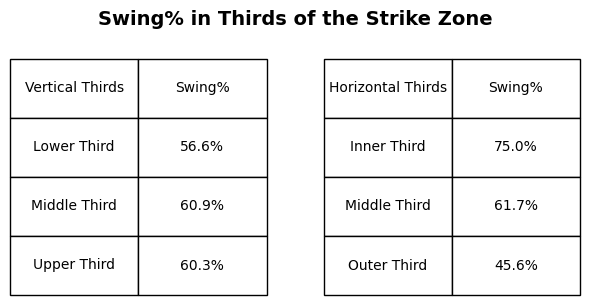

In [56]:
player_name = "Schmidt, Kent"
player_df = df[df["Batter"] == player_name].copy()
player_df = player_df.dropna(subset=["PlateLocSide", "PlateLocHeight"])

swing_events = ["FoulBallFieldable", "FoulBallNotFieldable", "InPlay", "StrikeSwinging"]
player_df["Swing"] = player_df["PitchCall"].isin(swing_events)

sz_left, sz_right = -0.83, 0.83
sz_bottom, sz_top = 1.5, 3.5

x_bins = [sz_left, sz_left + (sz_right - sz_left)/3,
          sz_left + 2*(sz_right - sz_left)/3, sz_right]
y_bins = [sz_bottom, sz_bottom + (sz_top - sz_bottom)/3,
          sz_bottom + 2*(sz_top - sz_bottom)/3, sz_top]

inside_sz_df = player_df[
    (player_df["PlateLocSide"] >= sz_left) &
    (player_df["PlateLocSide"] <= sz_right) &
    (player_df["PlateLocHeight"] >= sz_bottom) &
    (player_df["PlateLocHeight"] <= sz_top)
].copy()

def vertical_third(y):
    if y < y_bins[1]:
        return "Lower Third"
    elif y < y_bins[2]:
        return "Middle Third"
    else:
        return "Upper Third"

inside_sz_df["VertThird"] = inside_sz_df["PlateLocHeight"].apply(vertical_third)

vert_swing_stats = (
    inside_sz_df.groupby("VertThird")
    .agg(total_pitches=("Swing", "size"), swings=("Swing", "sum"))
    .reset_index()
)
vert_swing_stats["Swing%"] = (vert_swing_stats["swings"] / vert_swing_stats["total_pitches"]) * 100

def horizontal_third(x):
    if x < x_bins[1]:
        return "Inner Third"
    elif x < x_bins[2]:
        return "Middle Third"
    else:
        return "Outer Third"

inside_sz_df["HorThird"] = inside_sz_df["PlateLocSide"].apply(horizontal_third)

hor_swing_stats = (
    inside_sz_df.groupby("HorThird")
    .agg(total_pitches=("Swing", "size"), swings=("Swing", "sum"))
    .reset_index()
)
hor_swing_stats["Swing%"] = (hor_swing_stats["swings"] / hor_swing_stats["total_pitches"]) * 100

vert_data = vert_swing_stats[["VertThird", "Swing%"]].values
hor_data = hor_swing_stats[["HorThird", "Swing%"]].values

fig, ax = plt.subplots(figsize=(6, 3))
ax.axis("off")

fig.suptitle("Swing% in Thirds of the Strike Zone", fontsize=14, fontweight="bold", y=1)

vert_table = ax.table(
    cellText=[[v[0], f"{v[1]:.1f}%"] for v in vert_data],
    colLabels=["Vertical Thirds", "Swing%"],
    cellLoc="center",
    colLoc="center",
    loc="left",
    bbox=[0, 0, 0.45, 1]
)
vert_table.auto_set_font_size(False)
for key, cell in vert_table.get_celld().items():
    cell.set_fontsize(10)
    cell.set_height(0.1)

hor_table = ax.table(
    cellText=[[v[0], f"{v[1]:.1f}%"] for v in hor_data],
    colLabels=["Horizontal Thirds", "Swing%"],
    cellLoc="center",
    colLoc="center",
    loc="right",
    bbox=[0.55, 0, 0.45, 1]
)
hor_table.auto_set_font_size(False)
for key, cell in hor_table.get_celld().items():
    cell.set_fontsize(10)
    cell.set_height(0.1)

plt.tight_layout()
plt.show()